In [16]:
import qiskit
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute,transpile, assemble
from qiskit.tools.visualization import circuit_drawer
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate
from ibm_quantum_widgets import draw_circuit
from qiskit.visualization import plot_histogram
from numpy import pi
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import C3XGate
from IPython.display import Latex
from qiskit.visualization import state_visualization
from qiskit.circuit.library import C3XGate

In [17]:
#Code for a general Grover diffuser to amplify the solution states
def diffuser(nq):
    qb = QuantumCircuit(nq)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nq):
        qb.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nq):
        qb.x(qubit)
    # Do multi-controlled-Z gate
    qb.h(nq-1)
    qb.mct(list(range(nq-1)), nq-1)  # multi-controlled-toffoli
    qb.h(nq-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nq):
        qb.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nq):
        qb.h(qubit)
    # We will return the diffuser as a gate
    U_s = qb.to_gate()
    U_s.name = "Diffuser"
    return U_s

In [18]:
#The clauselist contains the restrictions(edges) of the graph which we are considering.
clauselist=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[3,4]]

#Change this to modify the number of times we iterate through the circuit.
#For the graph under consideration, we need 4 iterations
iterations=2

In [19]:
#Initiating the Quantum Register
vertex_qubits = QuantumRegister(10, name='vertex')
clause_qubits = QuantumRegister(14, name='clause')
secondcheck_qubits = QuantumRegister(5, name='second')
thirdcheck_qubits = QuantumRegister(2, name='third')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(10, name='cbits')
circuit = QuantumCircuit(vertex_qubits,clause_qubits,secondcheck_qubits,thirdcheck_qubits,output_qubit,cbits)

#Applying Hadamard gates to the 'vertex' qubits. To further simplify the problem, we fix the 3rd node color to '00'.
circuit.h([vertex_qubits[0],vertex_qubits[1],vertex_qubits[2],vertex_qubits[3],vertex_qubits[4],vertex_qubits[5],vertex_qubits[8],vertex_qubits[9]])
#Initiating the output qubit in |-> state
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)
#Adding a barrier between the initialization part and the Quantum Oracle
circuit.barrier()

In [20]:
#Quantum Oracle for the problem 
for t in range(iterations):
    i=0
    for clause in clauselist:
        #The divider list specifies which vertex qubits are assigned to each vertex in the graph
        #For the graph we consider, minimum of 4 colors is needed to fulfil all the clauses
        #We assign a color to each binary combination towards the end
        divider={0:[0,1],1:[2,3],2:[4,5],3:[6,7],4:[8,9]}
        flist=divider[clause[0]]
        slist=divider[clause[1]]
        #Applying the conditional NOT to check that the qubits in each clause are not in the same state
        circuit.cx(vertex_qubits[flist[0]],clause_qubits[i])
        circuit.cx(vertex_qubits[slist[0]],clause_qubits[i])
        circuit.cx(vertex_qubits[flist[1]],clause_qubits[i+1])
        circuit.cx(vertex_qubits[slist[1]],clause_qubits[i+1])
        i=i+2
    circuit.barrier()
    
    #In total there is 14 clause qubits and we use a second set of ancilliary qubits to check that they
    #are in the desirable state. Then we use another set of qubits to check the conditions of the second set.
    circuit.append(C3XGate(), [clause_qubits[0], clause_qubits[1], clause_qubits[2], secondcheck_qubits[0]])
    circuit.append(C3XGate(), [clause_qubits[3], clause_qubits[4], clause_qubits[5], secondcheck_qubits[1]])
    circuit.append(C3XGate(), [clause_qubits[6], clause_qubits[7], clause_qubits[8], secondcheck_qubits[2]])
    circuit.append(C3XGate(), [clause_qubits[9], clause_qubits[10], clause_qubits[11], secondcheck_qubits[3]])
    circuit.ccx(clause_qubits[12], clause_qubits[13],secondcheck_qubits[4])
    circuit.append(C3XGate(), [secondcheck_qubits[0], secondcheck_qubits[1], secondcheck_qubits[2], thirdcheck_qubits[0]])
    circuit.ccx(secondcheck_qubits[3], secondcheck_qubits[4],thirdcheck_qubits[1])
    circuit.ccx(thirdcheck_qubits[0], thirdcheck_qubits[1],output_qubit[0])
    circuit.barrier()
    
    #We apply the following gates to 'uncompute' the auxilliary qubits
    i=0
    for clause in clauselist:
        divider={0:[0,1],1:[2,3],2:[4,5],3:[6,7],4:[8,9]}
        flist=divider[clause[0]]
        slist=divider[clause[1]]
        circuit.cx(vertex_qubits[flist[0]],clause_qubits[i])
        circuit.cx(vertex_qubits[slist[0]],clause_qubits[i])
        circuit.cx(vertex_qubits[flist[1]],clause_qubits[i+1])
        circuit.cx(vertex_qubits[slist[1]],clause_qubits[i+1])
        i=i+2
    circuit.barrier()
    
    #Finally we apply the Diffuser to amplify the solution states
    circuit.append(diffuser(10), [0,1,2,3,4,5,6,7,8,9])
    circuit.barrier()


In [21]:
#Measuring the vertex Qubits
for j in range(10):
    circuit.measure(vertex_qubits[j], cbits[j])

In [22]:
#Use circuit.draw('mpl') for rendering in matplotlib
#circuit.draw()


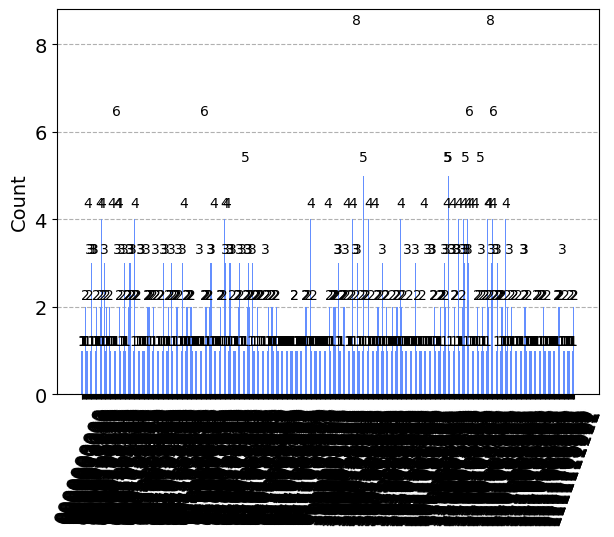

In [23]:
#We use the matrix product state simulator because the cicuit is large and
#all the other simulators need atleast 32GB of ram for the computation
#If your system have Nvidia GPU(s), consider installing the cuquantum and
#qiskit-aer-gpu packages and use a gpu simulator. It will considerably
#reduce the computation time
aer_sim = Aer.get_backend('aer_simulator_matrix_product_state')
transpiled_qc = transpile(circuit, aer_sim)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())


In [24]:
#{k: v for k, v in sorted(result.get_counts().items(), key=lambda item: item[1])}

1001010001


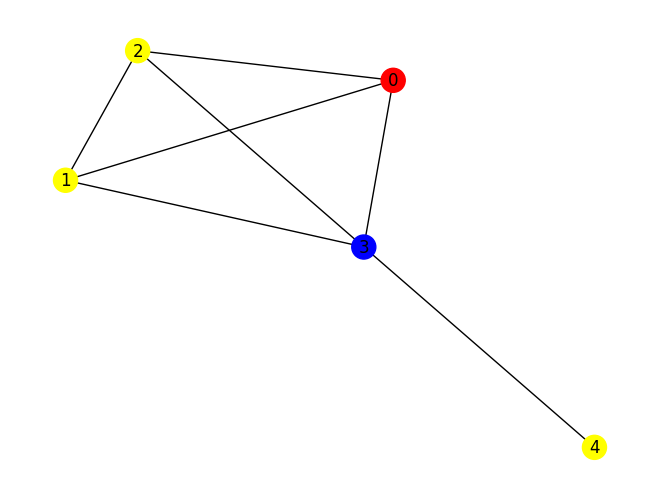

In [25]:
#This code takes the results from the previous computation, take the output states with the 
#highest number of occurances, convert it to big endian format. After that, using the networkx
#package, the required graph is drawn and the colors are assigned to the nodes from the results.
newdict={}
for k,v in sorted(result.get_counts().items(), key=lambda item: item[1]):
    newdict[k]=v
import networkx as nx
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(3,4)])
colordict={"00":"blue","01":"yellow","10":"red","11":"green"}

numst=list(newdict.keys())[-1]
string=str(numst)
strrev=string[::-1]
print(strrev)
ne = 2
chunks = [strrev[i:i+2] for i in range(0, len(strrev), ne)]
color_map = []
for b in chunks:
     color_map.append(colordict[b])
nx.draw(G, node_color=color_map, with_labels=True)




1101110011


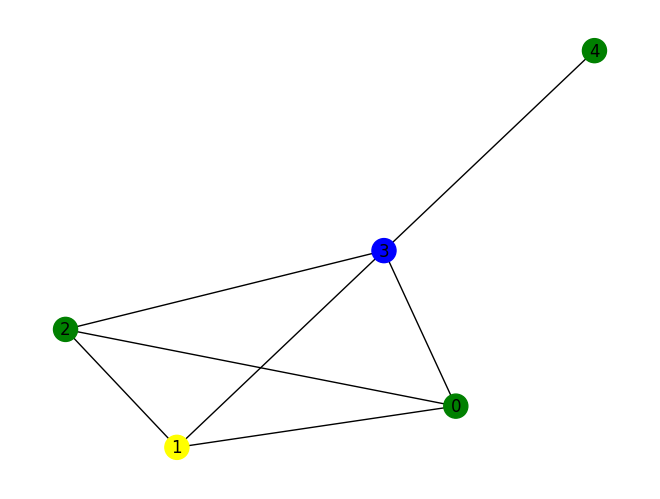

In [26]:
#This code block draws and assigns the color to the nodes based on the second
#most occured state. This code can be avoided and integrated into the previous block
#provided we add extra code to override the default IPython output block paramenters.
#Add the following code block if that's the format desired.
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

numst=list(newdict.keys())[-2]
string=str(numst)
strrev=string[::-1]
print(strrev)
ne = 2
chunks = [strrev[i:i+2] for i in range(0, len(strrev), ne)]
color_map = []
for b in chunks:
     color_map.append(colordict[b])
nx.draw(G, node_color=color_map, with_labels=True)




0110110000


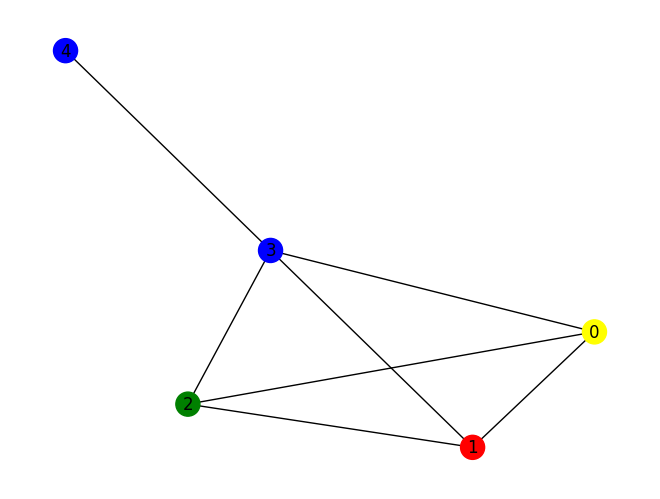

In [27]:
#Draws the third most common statement from the measurement

numst=list(newdict.keys())[-3]
string=str(numst)
strrev=string[::-1]
print(strrev)
ne = 2
chunks = [strrev[i:i+2] for i in range(0, len(strrev), ne)]
color_map = []
for b in chunks:
     color_map.append(colordict[b])
nx.draw(G, node_color=color_map, with_labels=True)


